/Users/ascott47/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/ascott47/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/ascott47/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/ascott47/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ascott47/anaconda/

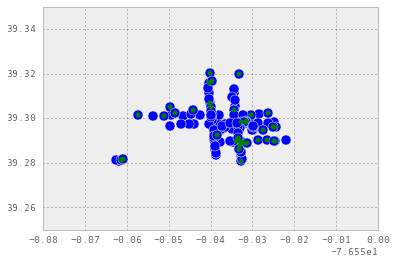

In [1]:
# worksheet for figures from "Constraining intra-urban variability"
# import data
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import matplotlib
import matplotlib.pylab as pylab
from mpl_toolkits.basemap import Basemap
pylab.rcParams['figure.figsize'] = 16, 12
pd.options.display.mpl_style = 'default'
get_ipython().magic(u'matplotlib inline')
import ibuttonplots
import importibuttondata
%matplotlib inline

files = glob.glob('./data/*[tT].csv')
meta0 = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))
#pd.DataFrame(pd.read_csv('./data/bmoremetadata.csv', sep = ','))
tempDF0, anomalyDF0, meta0 = importibuttondata.importdata(files, meta0)

#files = glob.glob('./data/*[tT].csv')
files = glob.glob('./data/falldownload/*[tT].csv')
meta1 = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))
#meta0 = pd.DataFrame(pd.read_csv('./data/bmoremetadata.csv', sep = ','))
tempDF1, anomalyDF1, meta1 = importibuttondata.importdata(files, meta1)

frames = [tempDF0, tempDF1]
tempDF = pd.concat(frames)
anomalyDF = pd.concat([anomalyDF0, anomalyDF1])
meta = pd.concat([meta0, meta1.loc()[np.setdiff1d(meta1.sensornumber, meta0.sensornumber)]])

# Import Science Center observation data
date_spec = {'Date': [2, 3]}
urbandf = pd.read_csv('./data/observations/urban/2138216847366dat.csv', 
                      sep = ',', 
                      parse_dates = {'Date':[2, 3]},
                      #parse_dates = ['YYYYMMDD', 'HHM'],
                      keep_date_col=True).set_index('Date')
#urbandf.Temp[urbandf.Temp == '****'] = 'NaN' # replace stars with nans
urbandf.Temp = (urbandf.Temp.astype('float')) #-32)*5/9. #change the data to float
urbandf.Temp[urbandf.Temp > 400] = 'NaN' #change unrealistic temp data to nan, data in F so 400 too high
urbandf = urbandf[~((urbandf.index.month == 2) & (urbandf.index.day == 29))] # get rid of leap years
#df.DEWP[df.DEWP == '****'] = 'NaN' # replace stars with nans
#df.DEWP = df.DEWP.astype('float') #change the data to float
urbandf = urbandf.resample('H')
urbandf.rename(columns = {'Temp' : 'TEMP'}, inplace = True)
urbandf.index = urbandf.index - pd.DateOffset(hours  = 4)

# Import hourly BWI data
date_spec = {'Date': [2]}
df = pd.read_csv('./data/observations/rural/4330976847362dat.csv', sep = ',', parse_dates = date_spec, keep_date_col=True).set_index('Date')
df.TEMP[df.TEMP == '****'] = 'NaN' # replace stars with nans
df.TEMP = (df.TEMP.astype('float')-32)*5/9. #change the data to float
df.TEMP[df.TEMP > 400] = 'NaN' #change unrealistic temp data to nan, data in F so 400 too high
df = df[~((df.index.month == 2) & (df.index.day == 29))] # get rid of leap years
df.DEWP[df.DEWP == '****'] = 'NaN' # replace stars with nans
df.DEWP = df.DEWP.astype('float') #change the data to float
ruraldf = df.resample('H')

import sqlite3
conn = sqlite3.connect('amazinggrace-weewx.sdb')
amazinggracedf = pd.read_sql_query('SELECT * from archive', conn)
amazinggracedf['dateTime']=pd.to_datetime(amazinggracedf['dateTime'], unit='s')
amazinggracedf.outTemp = (amazinggracedf.outTemp-32)*5./9.
amazinggracedf = amazinggracedf.set_index('dateTime')
amazinggracedf.index = amazinggracedf.index - pd.DateOffset(hours  = 5)

conn = sqlite3.connect('olinhall-weewx.sdb')
olinhalldf = pd.read_sql_query('SELECT * from archive', conn)
olinhalldf['dateTime']=pd.to_datetime(olinhalldf['dateTime'], unit='s')
olinhalldf.outTemp = (olinhalldf.outTemp-32)*5./9.
olinhalldf = olinhalldf.set_index('dateTime')
olinhalldf.index = olinhalldf.index - pd.DateOffset(hours  = 5)

amazinggracedf = amazinggracedf.resample('H')
olinhalldf = olinhalldf.resample('H')

# categorize sensors
ebaltsensorsi = np.where(meta['location:Longitude']>= -76.6125831)#-76.61)# -76.6072591 )
parksi = np.where((meta['landcoverclass'] != 'impervious') & (meta['location:Longitude']>= -76.6125831)) # -76.61) )
plt.scatter(meta['location:Longitude'].iloc[ebaltsensorsi],
            meta['location:Latitude'].iloc[ebaltsensorsi], s = 100)
plt.scatter(meta['location:Longitude'].iloc[parksi],
            meta['location:Latitude'].iloc[parksi], color = 'g')

parksensors = meta.sensornumber.iloc[parksi]
ebaltsensors = meta.sensornumber.iloc[ebaltsensorsi]
nonparks = np.setdiff1d(ebaltsensors, parksensors)

selected = ebaltsensors

pylab.rcParams['font.family'] = 'serif' 
pylab.rcParams['font.size'] = 14
pylab.rcParams['axes.titlesize'] = 22

In [2]:
startdate = '2015-06-01'
enddate = '2015-09-15'

In [5]:
#Results: compute statistics 
#perform a t-test
from scipy import stats
stats.ttest_ind(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').mean(), 
                     tempDF[startdate:enddate][parksensors].resample('D', how = 'min').mean(),
                     equal_var = False)

Ttest_indResult(statistic=8.173658532346149, pvalue=9.3130096953852321e-11)

In [6]:
# table of mean/ std deviation
# standard deviation computed to show sensor-to sensor variability, not variability in time
startdate = '2015-06-01'
enddate = '2015-09-25'
print startdate, " to " , enddate
print "    ", "Total", "Imp. ", "Green", "Difference"
print "Mean", "%2.2f"%tempDF[startdate:enddate].resample('D', how = 'min')[selected].mean().mean(), "%2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').mean().mean(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').mean().mean(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').mean().mean()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').mean().mean())
print "SD  ", " %2.2f"%tempDF[startdate:enddate].resample('D', how = 'min')[selected].std(), " %2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').mean().std(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').mean().std(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').mean().std()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').mean().std())
print 'range of the data is', tempDF[startdate:enddate].resample('D', how = 'min')[selected].mean().max()-tempDF[startdate:enddate].resample('D', how = 'min').mean().min()
print 'min = ',  tempDF[startdate:enddate].resample('D', how = 'min')[selected].mean().min()
print 'max = ',  tempDF[startdate:enddate].resample('D', how = 'min')[selected].mean().max()

2015-06-01  to  2015-09-25
     Total Imp.  Green Difference
Mean 21.36 21.66 20.74 0.92
SD  

TypeError: float argument required, not Series

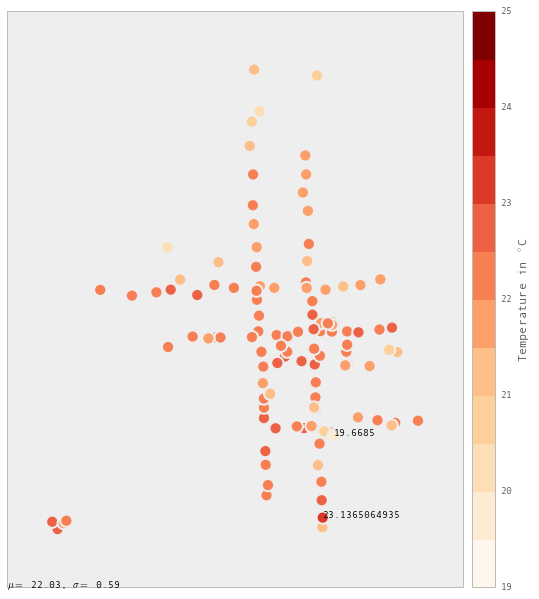

In [13]:
startdate = '2015-07-01'
enddate = '2015-09-15'
fig  = plt.figure(figsize=(30, 30))
x = meta['location:Longitude'].loc[selected].values
y = meta['location:Latitude'].loc[selected].values
c = tempDF[startdate:enddate].resample('D', how = 'min').mean(axis=0)[selected]#.values # The colors will show the mean temp at that location
marker_size = 150
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

m = Basemap(llcrnrlon=x.min()-.005,
            llcrnrlat=y.min()-.005,
            urcrnrlon=x.max()+.005,
            urcrnrlat=y.max()+.005,
            projection='mill',
            resolution ='h',
            epsg=3857
            )
#wms_server = "http://mapserver.org/mapcache"
#wms_server = "http://osm.woc.noaa.gov/mapcache"
#m.wmsimage(wms_server, layers = ["osm"], verbose = False)

#define the color map
cmap = matplotlib.cm.OrRd
#if anomaly == '':
bounds = np.linspace(round((c.mean()-3)),round((c.mean()+3)),13)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
#m.scatter()
celsius = m.scatter(x,y, s = marker_size, c =c ,#(c*9./5. + 32.),
                 cmap = cmap,
                 norm = norm,
                 #cmap = matplotlib.cm.RdBu_r,
                    latlon = True,
                    lw = 2,
                    #edgecolor = 'gray',
                    #vmin = (c.mean()-3)*9/5.,
                    #vmax = (c.mean()+3)*9/5.,
                    )
cbar1 = m.colorbar(celsius, location = 'right', label = 'Temperature in $^\circ $C')

i = np.argmin(c.values)
xx,yy = m(x[i], y[i])
plt.text(xx, yy, c.min())

i = np.argmax(c.values)
xx,yy = m(x[i], y[i])
plt.text(xx, yy, c.max())

plt.text(0,0, '$\mu = $ %2.2f, $\sigma = $ %2.2f'%(c.mean(), c.std()))
#plt.text(0,.1, c.std())

In [6]:
pylab.rcParams['font.family'] = 'serif' 
pylab.rcParams['font.size'] = 14
pylab.rcParams['axes.titlesize'] = 22

#ax.spines["top"].set_visible(False)  
#ax.spines["right"].set_visible(False)  

In [3]:
def prettify_plot(): 
    ""'Hides top and rightmos axis spines and also some other stuff. '""
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_axis_bgcolor('none')
    plt.grid(b=False, which='major')

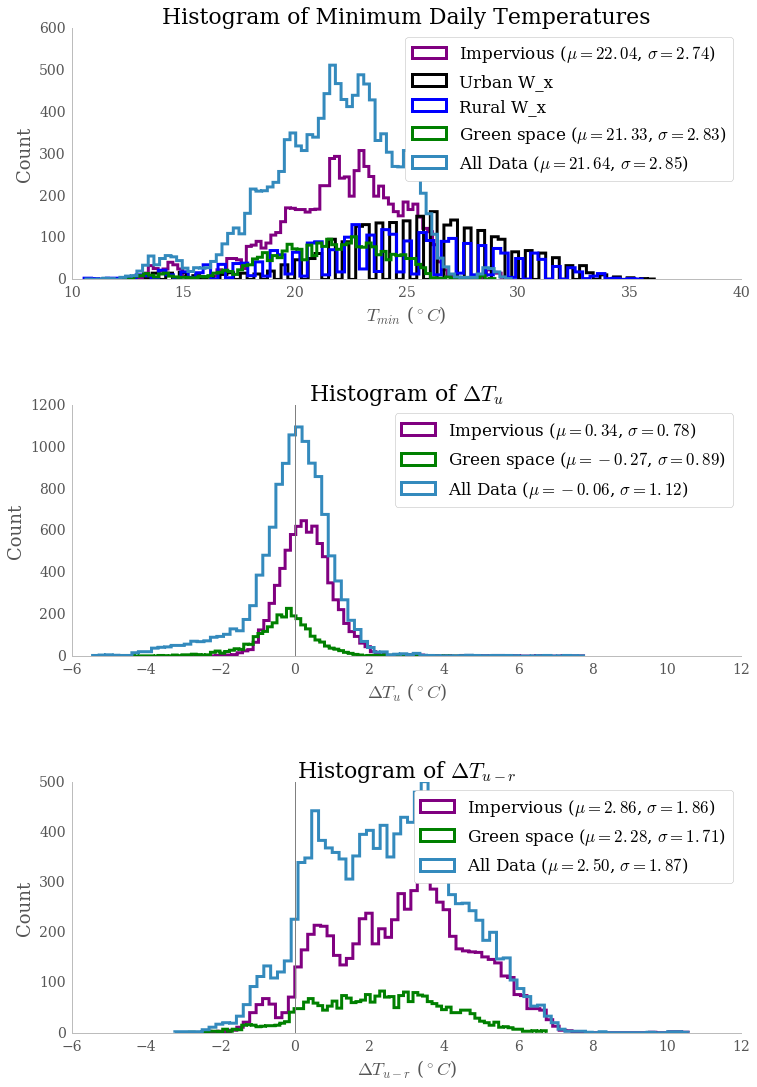

In [29]:
# Histograms plot 
fig = plt.figure(figsize=[12,18])
# Temperature histogram
plt.subplot(3,1,1)
M = 75 
data = tempDF[startdate:enddate][nonparks].resample('D', how = 'min').values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, color = 'purple',label = 'Impervious ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

n,bins, patches = plt.hist(urbandf[startdate:enddate].TEMP, M, histtype='step', linewidth = 3, color = 'black',label = 'Urban W_x')
n,bins, patches = plt.hist(ruraldf[startdate:enddate].TEMP, M, histtype='step', linewidth = 3, color = 'blue',label = 'Rural W_x')


data = tempDF[startdate:enddate][parksensors].resample('D', how = 'min').values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, color = 'green', label = 'Green space ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

data = tempDF[startdate:enddate].resample('D', how = 'min').values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, label = 'All Data ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.legend().get_frame().set_facecolor('white')
plt.title('Histogram of Minimum Daily Temperatures', fontsize = 22)
plt.xlabel('$ T_{min}$ ($^\circ C$)', fontsize=18)
plt.ylabel('Count', fontsize=18)
prettify_plot()

#intra-urban histogram
plt.subplot(3,1,2)
plt.axvline(0, color ='grey')
diff = tempDF[startdate:enddate].resample('D', how = 'min')-urbandf[startdate:enddate].resample('D', how = 'min').TEMP
data = diff[nonparks].values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, color = 'purple', label = 'Impervious ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))
data = diff[parksensors].values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, color = 'green',label = 'Green space ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

data = diff.values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, label = 'All Data ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.legend().get_frame().set_facecolor('white')
plt.title('Histogram of $\Delta T_u$', fontsize = 22)
plt.xlabel('$\Delta T_{u}$ ($^\circ C$)', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xlim([-6,12])
prettify_plot()

# urban-rural histogram 
plt.subplot(3,1,3)
plt.axvline(0,color = 'grey')
diff = tempDF[startdate:enddate].resample('D', how = 'min')-ruraldf[startdate:enddate].resample('D', how = 'min').TEMP
data = diff[nonparks].values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, color = 'purple', label = 'Impervious ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))
data = diff[parksensors].values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, color = 'green', label = 'Green space ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

data = diff.values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, label = 'All Data ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.legend().get_frame().set_facecolor('white')
plt.title('Histogram of $\Delta T_{u-r}$', fontsize = 22)
plt.xlabel('$\Delta T_{u-r}$ ($^\circ C$)', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xlim([-6,12])
prettify_plot()

plt.savefig('plots/histograms.eps', dpi = 300)

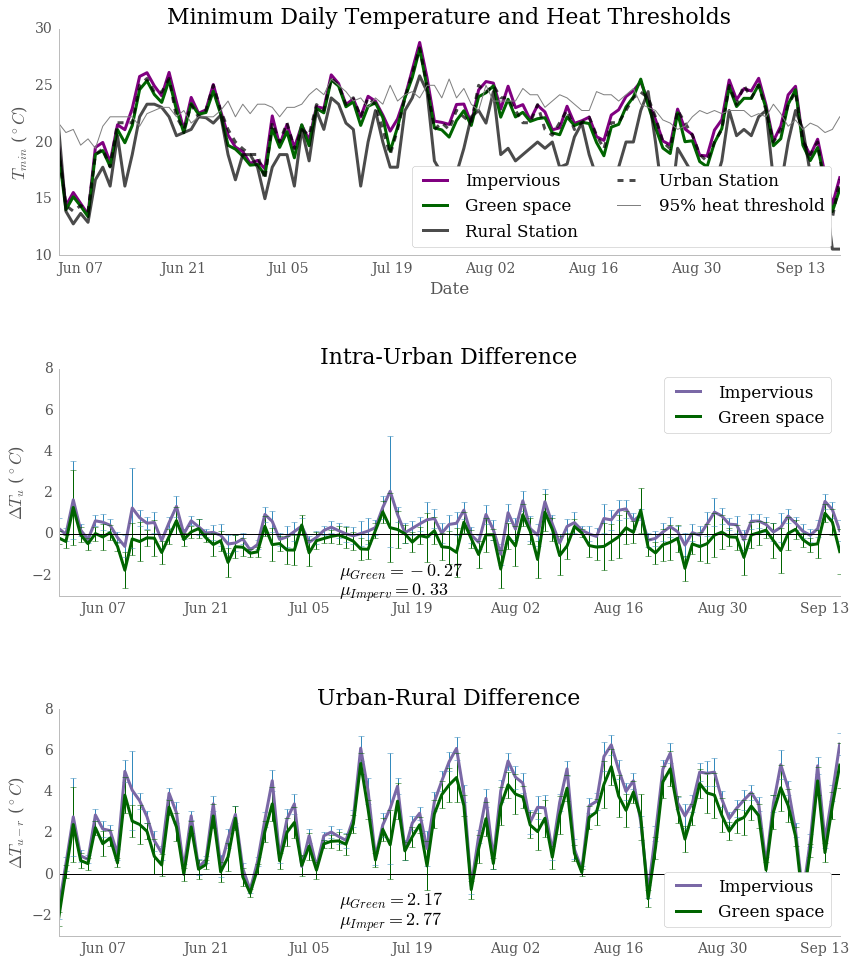

In [28]:
import matplotlib.dates as mdates
# time series
# Temperature
minthresh = (np.load('BWImindailytempthresholds.npy') -32) *5/9.
fig = plt.figure(figsize = [14,18])
ax = fig.add_subplot(311)
x = tempDF[startdate:enddate].resample('D',how = 'min').index.to_pydatetime()
ax.plot(x,tempDF[startdate:enddate].resample('D', how = 'min')[nonparks].mean(axis=1), 'purple', label = 'Impervious',  linewidth = 3)
ax.plot(x, tempDF[startdate:enddate].resample('D', how = 'min')[parksensors].mean(axis=1), color = 'DarkGreen',label = 'Green space', 
         linewidth = 3)

ruraldf[startdate:enddate].resample('D', how = 'min').TEMP.plot(label = 'Rural Station', linewidth = 3, color = 'k', alpha = .7)
urbandf[startdate:enddate].resample('D', how = 'min').TEMP.plot(style ='--k', label = 'Urban Station', linewidth = 3, alpha = .7)

plt.plot(x, minthresh[1][tempDF[startdate:enddate].resample('D', how='min').index.dayofyear-1],
         color = 'gray', linewidth = 1, label = '95% heat threshold')
plt.legend(loc =4, ncol = 2).get_frame().set_facecolor('white')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=0)
plt.title('Minimum Daily Temperature')
plt.ylabel('$T_{min}$ ($^\circ C$)')
prettify_plot()

### Intra-urban difference 
ax = fig.add_subplot(312)
diff = tempDF[startdate:enddate].resample('D', how = 'min')-urbandf[startdate:enddate].resample('D', how = 'min').TEMP
plt.errorbar(diff.index, diff[nonparks].mean(axis=1), yerr = diff[nonparks].std(axis=1))
plt.plot(diff.index, diff[nonparks].mean(axis=1), label = 'Impervious',linewidth = 3)
plt.errorbar(diff.index, diff[parksensors].mean(axis=1),yerr = diff[parksensors].std(axis=1),
    linewidth = 1, color = 'DarkGreen')
plt.plot(diff.index, diff[parksensors].mean(axis=1), label = 'Green space', linewidth = 3,  
         color = 'DarkGreen')
plt.axhline(0, color ='k')
lgd = plt.legend(selected, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 6)
plt.legend().get_frame().set_facecolor('white')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Intra-Urban Difference')
plt.ylabel('$\Delta T_{u}$ ($^\circ C$)')
plt.ylim([-3,8])
plt.text('2015-07-09', -2, '$ \mu_{Green} = %2.2f$'%diff[parksensors].mean(axis=1).mean(), 
         fontsize = 18)
plt.text('2015-07-09', -3, '$ \mu_{Imperv} = %2.2f$'%diff[nonparks].mean(axis=1).mean(), 
         fontsize = 18)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
prettify_plot()
### Urban-rural differences 
# Delta(Temperature), urban -rural
ax = fig.add_subplot(313)
diff = tempDF[startdate:enddate].resample('D', how = 'min')-ruraldf[startdate:enddate].resample('D', how = 'min').TEMP
plt.errorbar(diff.index, diff[nonparks].mean(axis=1), yerr = diff[nonparks].std(axis=1),
              #color = pd.tools.plotting._get_standard_colors(3)[0], linewidth = 1
            )
plt.plot(diff.index, diff[nonparks].mean(axis=1),
         label = 'Impervious',
          #color = pd.tools.plotting._get_standard_colors(3)[0], 
          linewidth = 3, )
plt.errorbar(diff.index, diff[parksensors].mean(axis=1),yerr = diff[parksensors].std(axis=1),
    linewidth = 1, 
    color = 'DarkGreen',#color = pd.tools.plotting._get_standard_colors(3)[1]  
            )

plt.plot(diff.index, diff[parksensors].mean(axis=1), label = 'Green space',
         linewidth = 3,  
         color = 'DarkGreen',#color = pd.tools.plotting._get_standard_colors(3)[1]
        )
plt.axhline(0, color ='k')
lgd = plt.legend(selected, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 6)
plt.legend(loc = 4).get_frame().set_facecolor('white')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Urban-Rural Difference')
plt.ylabel('$\Delta T_{u-r}$ ($^\circ C$)')
plt.ylim([-3,8])
# annotate means
plt.text('2015-07-09', -1.5, '$ \mu_{Green} = %2.2f$'%diff[parksensors].mean(axis=1).mean(), 
         fontsize = 18)
plt.text('2015-07-09', -2.5, '$ \mu_{Imper} = %2.2f$'%diff[nonparks].mean(axis=1).mean(), 
         fontsize = 18)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
prettify_plot()
plt.savefig('plots/triplot.eps', dpi = 300)

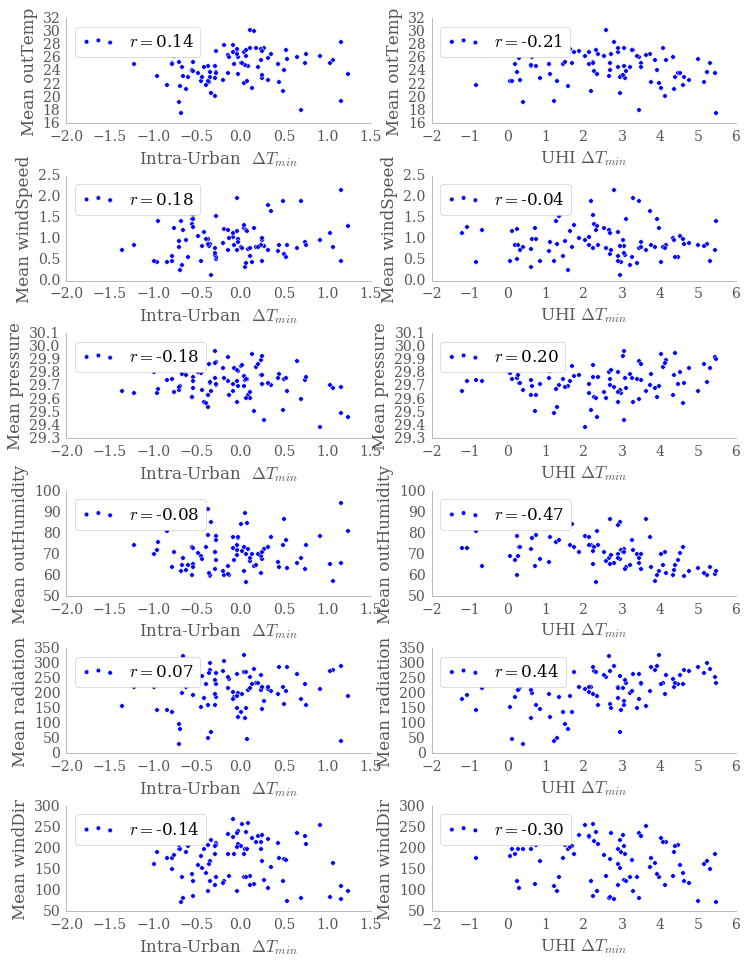

In [34]:
startdate = '2015-06-15'
UHI =  tempDF[startdate:enddate].resample('D', how = 'min')-ruraldf[startdate:enddate].resample('D', how = 'min').TEMP
UHI = UHI.mean(axis=1)
Intra = tempDF[startdate:enddate].resample('D', how = 'min')-urbandf[startdate:enddate].resample('D', how = 'min').TEMP
Intra = Intra.mean(axis=1)

n = 1
fig1 = plt.figure(figsize=[12,16])
for variable in ['outTemp', 'windSpeed', 'pressure', 'outHumidity', 'radiation', 'windDir']: 
    plt.subplot(6,2,n)
    try: 
        x = olinhalldf[startdate:enddate][variable].resample('D', how= 'mean')
        plt.scatter(Intra[1:],x[0:-1])
        plt.ylabel('Mean %s'%variable)
        plt.xlabel('Intra-Urban  $\Delta T_{min}$')
        plt.legend(['$r=$%.2f'%np.corrcoef(Intra[1:],x[0:-1])[0,1]], loc ='upper left').get_frame().set_facecolor('white')
        prettify_plot()
        
        plt.subplot(6,2,n+1)
        plt.scatter(UHI[1:],x[0:-1])
        plt.ylabel('Mean %s'%variable)
        plt.xlabel('UHI $\Delta T_{min}$')
        plt.legend(['$r=$%.2f'%np.corrcoef(UHI[1:],x[0:-1])[0,1]], loc ='upper left').get_frame().set_facecolor('white')
        prettify_plot()
        
    except IndexError: 
                print 'error: cannot map %s'%variable
    except KeyError : 
            print 'error: cannot map %s'%variable    
    n= n+2
    

In [83]:
for variable in ['outTemp', 'windSpeed', 'pressure', 'outHumidity', 'radiation', 'windDir']:
    diff = amazinggracedf[startdate:enddate][variable].resample('D', how= 'mean') - olinhalldf[startdate:enddate][variable].resample('D', how= 'mean')
    print variable, diff.mean()

outTemp 1.34228543035
windSpeed 0.595249733692
pressure -0.0131042517134
outHumidity -6.55501797578
radiation 19.1893624029
windDir 5.04500281123


In [103]:
hwthresh = minthresh[1][tempDF[startdate:enddate].resample('D', how='min').index.dayofyear-1]
#print hwthresh.shape, tempDF[nonparks][startdate:enddate].resample('D', how = 'min').mean(axis=1).shape
hwindex = np.where(tempDF[startdate:enddate].resample('D', how = 'min').mean(axis=1) >= hwthresh)
hwdays = tempDF[startdate:enddate].resample('D', how = 'min').index[hwindex]
print startdate, " to " , enddate, "heatwave days (n= %i/%i)"%(hwdays.shape[0],  tempDF[nonparks][startdate:enddate].resample('D', how = 'min').index.shape[0]-hwdays.shape[0])
print "    ", "Total", "Imp. ", "Green", "Difference"
print "Mean", "%2.2f"%tempDF[startdate:enddate].resample('D', how = 'min').loc[hwdays].mean().mean(), "%2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[hwdays].mean().mean(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[hwdays].mean().mean(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[hwdays].mean().mean()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[hwdays].mean().mean())
print "SD  ", " %2.2f"%tempDF[startdate:enddate].resample('D', how = 'min').loc[hwdays].mean().std(), " %2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[hwdays].mean().std(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[hwdays].mean().std(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[hwdays].mean().std()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[hwdays].mean().std())

nonhwdays = np.setdiff1d(tempDF[startdate:enddate].resample('D', how = 'min').index, hwdays )
print startdate, " to " , enddate, " non- heatwave days (n= %i/%i)"%(nonhwdays.shape[0],  tempDF[nonparks][startdate:enddate].resample('D', how = 'min').index.shape[0])
print "    ", "Total", "Imp. ", "Green", "Difference"
print "Mean", "%2.2f"%tempDF[startdate:enddate].resample('D', how = 'min').loc[nonhwdays].mean().mean(), "%2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[nonhwdays].mean().mean(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[nonhwdays].mean().mean(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[nonhwdays].mean().mean()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[nonhwdays].mean().mean())
print "SD  ", " %2.2f"%tempDF[startdate:enddate].resample('D', how = 'min').loc[nonhwdays].mean().std(), " %2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[nonhwdays].mean().std(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[nonhwdays].mean().std(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[nonhwdays].mean().std()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[nonhwdays].mean().std())

2015-05-29  to  2015-09-25 heatwave days (n= 35/85)
     Total Imp.  Green Difference
Mean 23.92 24.37 23.70 0.68
SD    0.78  0.31 0.47 -0.16
2015-05-29  to  2015-09-25  non- heatwave days (n= 85/120)
     Total Imp.  Green Difference
Mean 19.99 20.58 19.44 1.14
SD    1.00  0.41 0.95 -0.54


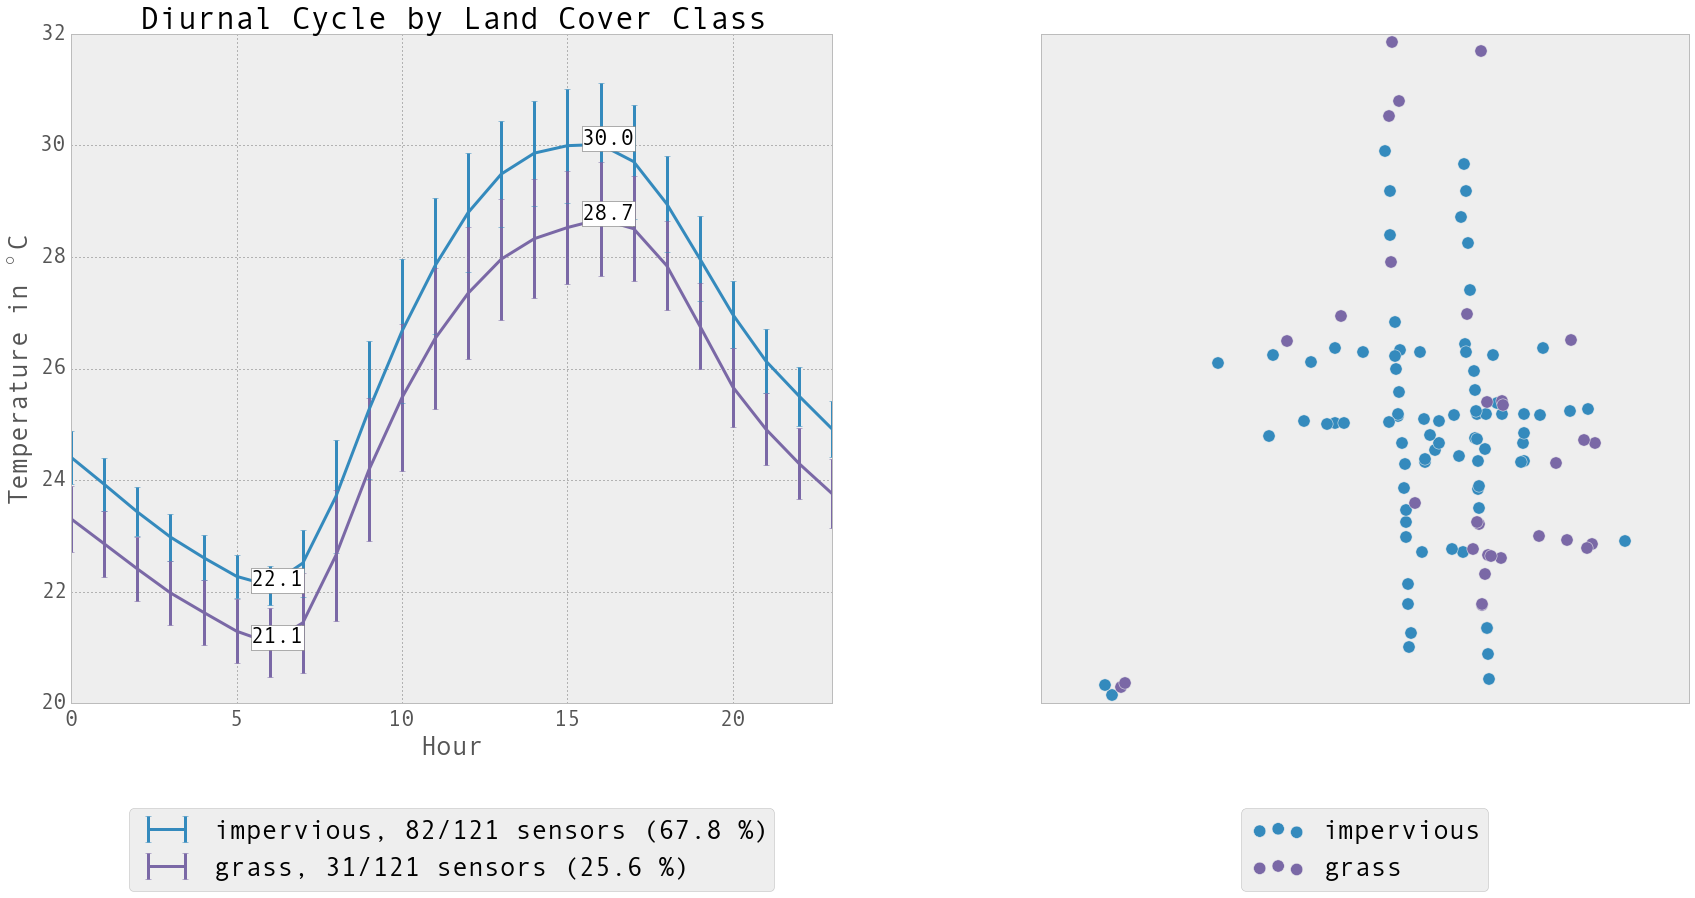

In [104]:
diurnalDF =  tempDF[selected][startdate:enddate]
diurnalDF["hour"] = tempDF[startdate:enddate].index.hour
diurnalDF.set_index("hour")
ibuttonplots.diurnalplots(diurnalDF, meta.loc[selected],'landcoverclass')

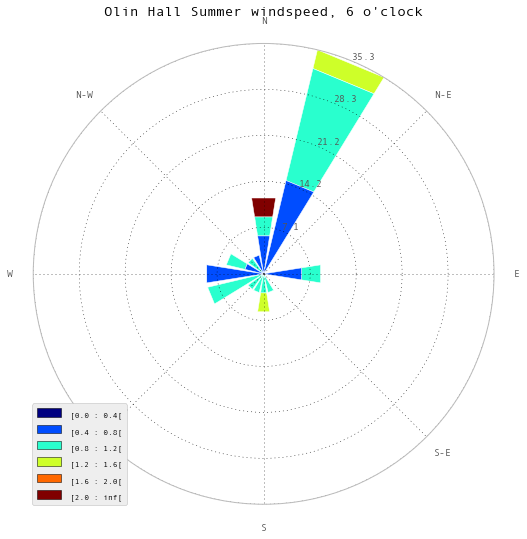

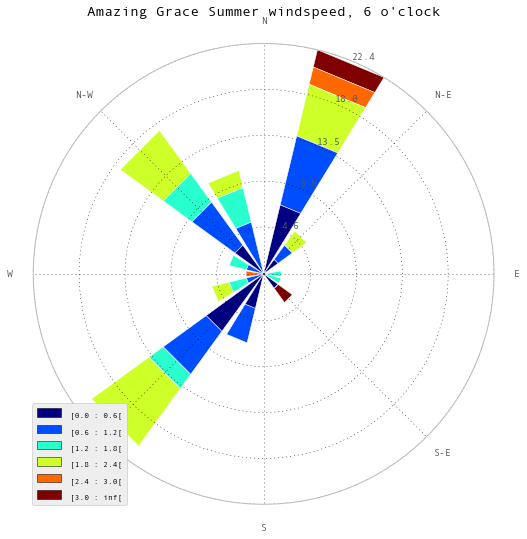

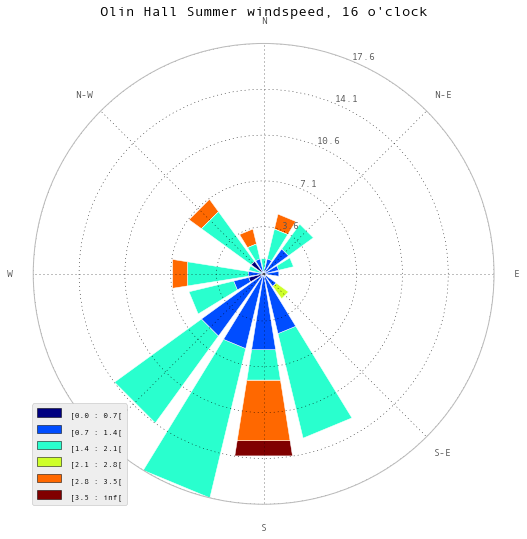

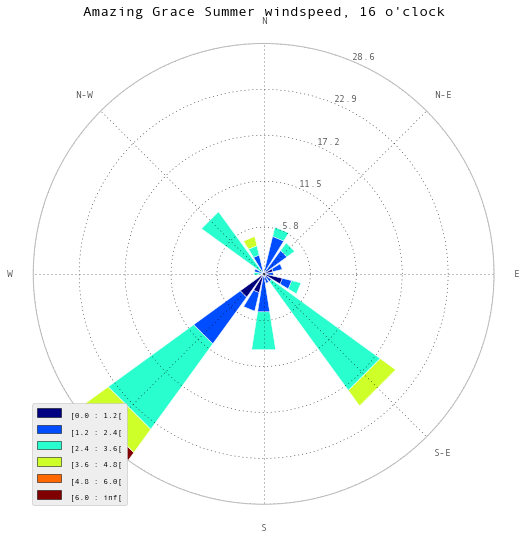

In [3]:
from windrose import WindroseAxes
startdate = '2015-06-24' 
enddate = '2015-09-25'
hour = 6
ax = WindroseAxes.from_ax()
ax.bar(olinhalldf[olinhalldf.index.hour==hour][startdate:enddate].windDir, olinhalldf[olinhalldf.index.hour==hour][startdate:enddate].windSpeed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Olin Hall Summer windspeed, %i o\'clock'%hour)

ax = WindroseAxes.from_ax()
ax.bar(amazinggracedf[amazinggracedf.index.hour==hour][startdate:enddate].windDir, 
       amazinggracedf[amazinggracedf.index.hour==hour][startdate:enddate].windSpeed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Amazing Grace Summer windspeed, %i o\'clock'%hour)

hour = 16
ax = WindroseAxes.from_ax()
ax.bar(olinhalldf[olinhalldf.index.hour==hour][startdate:enddate].windDir, olinhalldf[olinhalldf.index.hour==hour][startdate:enddate].windSpeed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Olin Hall Summer windspeed, %i o\'clock'%hour)

ax = WindroseAxes.from_ax()
ax.bar(amazinggracedf[amazinggracedf.index.hour==hour][startdate:enddate].windDir, 
       amazinggracedf[amazinggracedf.index.hour==hour][startdate:enddate].windSpeed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Amazing Grace Summer windspeed, %i o\'clock'%hour)